### 0. 데이터 명세

In [1]:
'''
Header Information
고객번호,성별,연령대,주소(시도),고객등급,고객투자성향
df_cus.columns = ['cus_id', 'sex_dit_cd', 'cus_age', 'zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd']
계좌번호,고객번호,계좌개설년월
df_act.columns = ['act_id', 'cus_id', 'act_opn_ym']
종목코드,종목영문명,종목한글명
df_iem.columns = ['iem_cd', 'iem_eng_nm', 'iem_krl_nm']
계좌번호,주문날짜,주문순서,주문접수시간대,최종체결시간대,종목코드,매매구분코드,체결수량,체결가격,주문매체구분코드
df_trd_kr.columns = ['act_id', 'orr_dt', 'orr_ord', 'orr_rtn_hur', 'lst_cns_hur', 'iem_cd', 'sby_dit_cd', 'cns_qty', 'orr_pr', 'orr_mdi_dit_cd']
'''

path_cus = "cus_info.csv"
path_act = "act_info.csv"
path_iem = "iem_info.csv"
path_trd_kr = "trd_kr.csv"
path_trd_oss = "trd_oss.csv"

### 0.1 라이브러리 호출

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pyecharts import Scatter, Line, Overlap, Grid, EffectScatter, Bar, Boxplot, Pie, Scatter3D

### 0.2 함수 호출

In [3]:
#path1의 csv와 path2의 csv를 결합시켜준다 | label_name: 병합기준컬럼
def merge_csv(path1,path2,label_name,result_path):
    data1 = pd.read_csv(path1)
    data2 = pd.read_csv(path2)
    result = pd.merge(data1, data2, how = 'left', on = label_name)
    if not result_path:
        return result
    else:
        result.to_csv(result_path, index=False)
        
#path1의 csv파일을 샘플링해준다 | #percentile: 샘플링 비율 , seed: 시드값
def sampling_csv(path1,percentile,seed,result_path):
    data1 = pd.read_csv(path1)
    result, dummy = train_test_split(data1, train_size=percentile, random_state=seed)
    result.to_csv(result_path, index=False)
    if not result_path:
        return result
    else:
        result.to_csv(result_path, index=False)
        
#path1의 csv파일을 특정 컬럼의 범주별로 스플릿해서 저장
def split_csv(path1, label_name, prefix_path):
    data1 = pd.read_csv(path1)
    data1 = data1.sort_values(by=label_name)
    for i in data1[label_name].unique():
        temp = data1[data1[label_name] == i]
        temp.to_csv("{:}_{:}.csv".format(prefix_path,i), index=False)

def split_data_by_percentile(data1, label_name, percentile1, percentile2, how): #percentile: 비율 , how: 'q'/'c'  전체 데이터 수에 대해서/누적값에 대해서
    label_data = data1[label_name]
    label_data = label_data.sort_values(ascending=False)
    if how=='ca':
        label_data = label_data[::-1]
    percentile1, percentile2 = percentile1*0.01, percentile2*0.01
    if how == 'q': #Qunatile Function
        return data1[(label_data.values >= label_data.quantile(q=percentile1)) & (label_data.values <= label_data.quantile(q=percentile2))]
    if how == 'ca' or how == 'cd': #Accumulative Ascending & Descending
        cum_data = label_data.cumsum()
        target1 = cum_data.iloc[-1] * percentile1
        target2 = cum_data.iloc[-1] * percentile2
        return data1[(cum_data.values >= target1) & (cum_data.values <= target2)]
    print("Invaled Tag ['q' or 'ca' or 'cd']")
    return None

def swap_column(df, i, j):
    temp = df.columns.tolist()
    temp[i], temp[j] = df.columns[j], df.columns[i]
    return df[temp]

### 0.3 폰트 설정

In [4]:
# 한글 사용시 마이너스 폰트가 깨지는 문제가 발생할 수 있으므로 설정변경
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~~~~~')

### 0.4 그래프 색상 설정


In [5]:
sns.set_palette("pastel")
#c = sns.color_palette("pastel")
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# 
## 1. EDA (데이터 분석)
#### "밀레니얼,z세대' 부상.. 기업, 새 소비자층 이해해야 생존"

##### 현재 국내 주력 소비 세대가 베이비부머·X세대에서 밀레니얼·Z세대로 전환하고 있다. 
##### 이들은 기술과 변화에 민감할 뿐만 아니라 이를 소비활동에도 적극적으로 활용하고 있다. 

##### 이에 따라 인간 생활의 세 가지 기본 요소인 '의식주' 트렌드가 급변하고 있어 Z세대는 Y세대를 뒤잇는 향후 소비 시장의 주역으로 각광받고 있다.

##### 따라서 우리는 먼저 각 데이터 명세가 가지는 의미를 파악하고, 이를 활용할 수 있는 방법을 모색한 뒤 최종적으로 데이터 군집 기법을 활용해 Y세대와 Z세대가 주식 투자에 어떤 영향을 미치는지 알아보고자 한다. 

# 
## 1.1 데이터 병합 및 샘플링하기
##### 데이터 관계를 이해한 뒤, 고객의 정보와 계좌 정보, 그리고 주식 거래 정보를 모두 통합하였다. 추후 생성된 군집들의 일반화를 확보하기 위해 미리 데이터를 샘플링하는 함수도 만들어두었다.

In [6]:
# 작업 시간이 오래 걸리니 유의바람.
# sampling_csv(path_trd_kr,0.05,100,"trd_kr_s100.csv")
# merge_csv(path_act,path_cus,'cus_id','merged_act_cus.csv')
# merge_csv("trd_kr_s100.csv","merged_act_cus.csv",'act_id','merged_s100.csv')
# merge_csv(path_trd_kr,"merged_act_cus.csv",'act_id','merged_TKAC.csv')
# merge_csv(path_trd_oss,'merged_act_cus.csv','act_id','merged_TOAC.csv')
print("Done!")

Done!


# 
## 2. 데이터 분포 확인
##### 결합된 데이터들의 컬럼 별 정보를 얻기 위해서, 제일 먼저 히스토그램 분포를 파악해보았다.

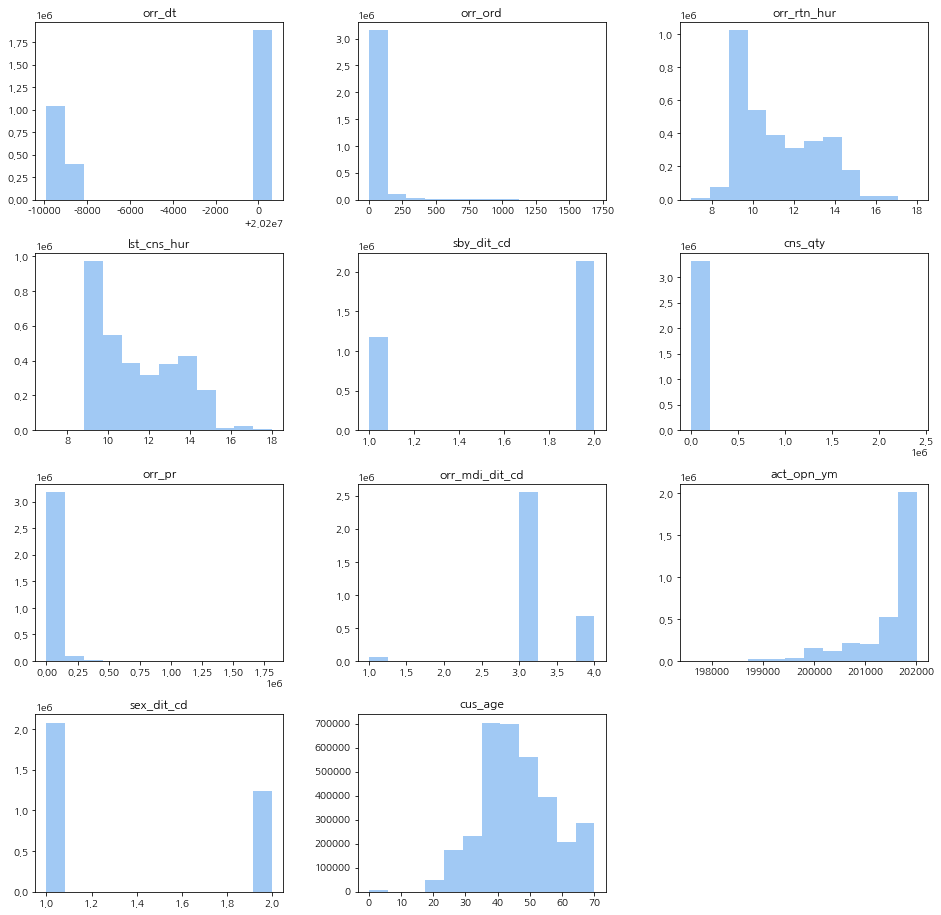

In [7]:
#df = pd.read_csv("merged_s100.csv") #샘플링 데이터
df = pd.read_csv("merged_TKAC.csv")
df.hist(bins=12, figsize=(16,16), grid=False)
plt.show()

## 
### 2.1 히스토그램 분석
##### 히스토그램 도출 결과 각 컬럼의 정보는 다음과 같다.

|제 목|변수명|설명|
|---|---|---|
|주문 날짜|orr_dt|좌우 끝으로 치우친 히스토그램이 나타나는데, 이는 날짜 데이터를 전처리 하지 않아서 발생한 문제이다.|
|주문순서|orr_ord|거의 모든 거래 데이터의 주문 순서가 200번대 이하임을 알 수 있다.|
|거래 시간대|orr_rtn_hur, lst_cns_hur|접수 시간대와 체결 시간대가 거의 유사함을 알 수 있다. 그러나 접수 시간대의 경우 개장 이전에 접수를 걸어둔 주문이 존재하는데, 해당 주문의 경우 시가를 결정지을 수 있는 중요한 요소이므로 일반적인 주문보다 더 분석적인 경향이 강하다고 할 수 있다. 해당 시간대에 Y세대와 Z세대의 존재 여부로 그들의 분석 경향을 유추할 수 있다.|
|매매 구분 코드|sby_dit_cd|전체 매도 수량과 매수 수량은 1:1로 대응될거라는 예상과는 달리, 주문 횟수는 다르다는 인사이트를 얻을 수 있었다. 즉, 주식을 살 때는 분할해서 사는 경향이 강한 반면, 팔때는 한 번에 파는 경향이 강하다는 것을 예측할 수 있다. 이런 편향성으로 인해 두 데이터를 하나로 취급하지 않고, 따로 분류해서 군집 분석에 사용할 예정이다.|
|주문 매체 코드|orr_mdi_dit_cd|현재 주식 투자 매체의 대세가 홈트레이딩(HTS, PC) 에서 모바일트레이딩(MTS, Mobile)로 넘어온 것을 확인할 수 있다. 그러나 이 또한 세대별로 그 분포가 다를 것으로 예상된다.|
|체결수량|cns_qty|체결수량의 경우 해당 주식 종목이 가격이 낮을수록 그 수량이 많아지고 높을 수록 수량이 작아지므로 유의미한 데이터는 아니다.  해당 종목의 주가(orp_pr) 과 함께 보아야 제대로 된 의미를 나타낼 것이다.|
|성별|sex_dit_cd|주식 투자 성별의 비가 남녀 2:1이라는 인사이트를 얻을 수 있다.|
|연령|cus_age| 35세 이전의 사용자 분포가 낮다는 것을 알 수 있는데, 더 많은 이용자를 확보하기 위한 방법을 모색해야 할 것이다.|

## 
### 2-2. 주식 거래량 변화 분석
#### 주식 거래량은 어떻게 변화하고 있을까?
##### 주문 날짜에 따른 주문량을 시계열로 분석하여 최근 주식 거래량의 동향을 파악해보았다.

### 
#### 2-2-1. 전체 거래량 분석

In [8]:
df1 = df.copy()
df1['orr_dt'] = pd.to_datetime(df1['orr_dt'],format='%Y%m%d')
print("데이터 상 거래 시작일 : ",df1['orr_dt'].min())
print("데이터 상 거래 종료일 : ",df1['orr_dt'].max())
#target_date = pd.Timestamp('2019-01-01')
#df1['orr_dt_fix'] = df1['orr_dt'] - target_date
df2 = df1['orr_dt'].value_counts().sort_index()

데이터 상 거래 시작일 :  2019-01-02 00:00:00
데이터 상 거래 종료일 :  2020-06-30 00:00:00


In [9]:
bar =Bar("Bar chart", "날짜 별 주식 거래량")
bar.add("Trade", df2.index, df2.values)
bar.height = 500; bar.width = 800
bar

##### 2020년 초부터 주식 거래량이 급증했음을 알 수 있다. 총 18개월 정도의 데이터가 있는데, Y세대, Z세대의 주식 거래 동향을 파악하기 위해 거래량이 급증하기 시작한 시기로 범위를 압축하여 2019년 11월 부터의 시계열 데이터를 다시 분석해보았다.

### 
#### 2-2-2. Y&Z 세대 거래량 분석

In [40]:
df1 = df.copy()
df1['orr_dt'] = pd.to_datetime(df1['orr_dt'],format='%Y%m%d')
target_date = pd.Timestamp('2019-11-01')
df1['orr_dt_fix'] = df1['orr_dt'] - target_date
df2 = df1[df1['orr_dt_fix'].dt.days >=0]
df3 = df2['orr_dt_fix'].value_counts().sort_index()
df4 = df3.rolling(window=10).mean()

In [43]:
line = Line("라인")
line.add("Line", (df4.index + target_date).strftime('%Y-%m-%d') , df4.values)

scatter = Scatter("점")
scatter.add("scatter", (df3.index + target_date).strftime('%Y-%m-%d'),df3.values, symbol_size = 3 )

overlap = Overlap()
overlap.add(line)
overlap.add(scatter)
overlap.height = 500; overlap.width = 800
overlap

In [44]:
line = Line("평균 거래량")
target_age = [20, 25, 30, 35]
for i in target_age:
    temp = df2[df2['cus_age'] == i]
    temp = temp['orr_dt_fix'].value_counts().sort_index()
    temp = temp.rolling(window=10).mean()
    line.add(str(i),(temp.index + target_date).strftime('%Y-%m-%d'), temp.values)
line

##### 10일 평균 거래량 시계열 그래프를 통해, 25세 이후부터 2020년 투자에 대한 관심이 증가하였음을 알 수 있었다. 그러나 20~25세 연령대의 경우 거래량이 다른 집단에 비해 크게 증가하지는 않았음을 알 수 있다.

## 
### 2.3 주식 거래 규모 파악
#### 연령 별 주식 활동량은 어떻게 될까?
##### 한 건의 거래 데이터에서 해당 거래의 규모가 얼마나 큰 건이었는지를 알기 위해서는 체결 수량과 체결 가격을 곱하여서 거래액을 확인해보면 된다. 하지만 우리는 특정 사용자가 얼마나 거래를 활발하게 하는가를 파악하고 이를 Y세대와 Z세대에 적용할 예정이기 때문에, 각 사용자별 거래액을 파악할 필요가 있을 것이다.

### 
#### 2-3-1. 전체 규모 파악

In [134]:
df1 = df.copy()
df1['money'] = df1['cns_qty']*df1['orr_pr']
df2 = pd.DataFrame(df1.groupby(['cus_id','cus_age','tco_cus_grd_cd'])['money'].sum())
df2.sort_values(by='money',ascending=False,inplace=True)
df2.rename(columns = {'money' : 'money_sum'}, inplace = True)
df2.reset_index(level=[0,1,2], inplace = True)

df_tmp1 = df1[['cus_age', 'money']].sort_values(by = 'cus_age').set_index('cus_age')
temp = []
for i in df_tmp1.index.unique():
    temp_i = df_tmp1[df_tmp1.index == i].values.flatten()
    temp.append(temp_i)

In [135]:
line = Line("고객별 거래금액")
line.add("money_sum ", df2.index, df2['money_sum'], legend_pos='25%')
line

boxplot = Boxplot("연령별 분류", title_pos='50%')
temp2 = boxplot.prepare_data(temp)
boxplot.add("Money",df_tmp1.index.unique(), temp2, legend_pos='80%')
boxplot

grid = Grid()
grid.add(line, grid_right='60%')
grid.add(boxplot, grid_left="60%")
grid.height = 300; grid.width = 800
grid

#### 
##### 데이터 분석 결과 사용자별 거래 활동 금액의 차이가 꽤 크다는 것을 알 수 있었다. 보다 정확한 데이터 분석을 위해, boxplot에서 outlier를 제거하고, 해당 outlier 군집을 대상으로 한 번 더 boxplot을 그린 후 결과를 관찰하기로 한다.

### 
#### 2-3-2. 이상치 제거

In [136]:
outliers = [ol for stat in boxplot_stats(df2['money_sum']) for ol in stat['fliers']]
df3 = pd.DataFrame(columns=df2.columns)
for i in outliers:
    df3 = df3.append(df2[df2['money_sum']==i],ignore_index=True)

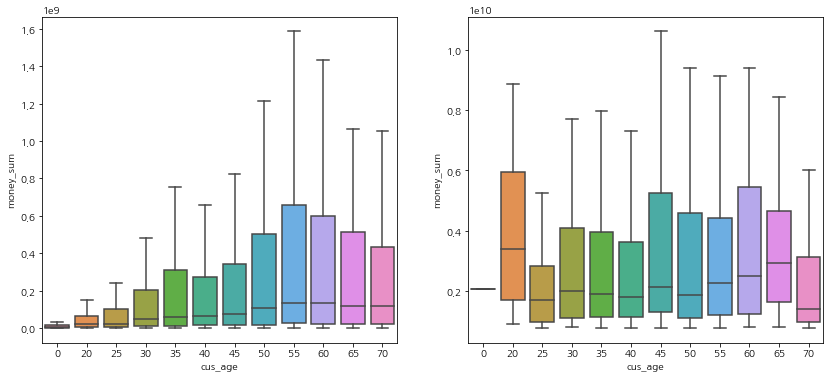

In [137]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1,2,1)
sns.boxplot(x='cus_age',y='money_sum',data=df2, ax=ax, showfliers=False)
ax = fig.add_subplot(1,2,2)
sns.boxplot(x='cus_age',y='money_sum',data=df3, ax=ax, showfliers=False)
sns.boxplot
plt.show()

#### 
##### outlier를 배제한 boxplot (왼쪽) 에 따르면 연령대가 증가할수록 거래가 활발한 사용자가 대체로 더 많음을 확인할 수 있다. 그리고 오른쪽 boxplot을 통해 outlier 집단에 속한 상위 주식 투자자들의 군집은 연령대별로 대체로 비슷한 경향을 보이는 것을 관찰할 수 있다. 그 중 조금 눈에 띄는 것은 Z세대 초반의 상위 투자자의 IQR 폭이 높다는 것인데, 이를 통해 20대 연령층은 주식을 하는 사용자의 편차가 다른 연령층에 비해 더 크다는 것을 확인할 수 있다.

## 
### 2-4. 주문 매체의 변화
#### 홈트레이딩(HTS) 에서 모바일 트레이딩(MTS) 으로
##### 주식 투자 매체의 대세가 홈트레이딩(HTS, PC) 에서 모바일트레이딩(MTS, Mobile)로 넘어온 건 누구나 아는 사실이다. 그러나 세대별 분포를 통해 Y세대와 Z세대가 얼마나 모바일 트레이딩을 이용하는지 그 비율을 분석하고자 한다.

In [81]:
df1 = df.copy()
df2 = pd.DataFrame(df1.groupby(['cus_age','orr_mdi_dit_cd'])['act_id'].count()).unstack()
df2.fillna(0,inplace=True)
df2.columns = df2.columns.droplevel(0)
df2.rename(columns = {1: '영업점단말' , 2: '유선단말', 3: '무선단말MTS' , 4: 'HTS' }, inplace = True)

df_list = [df2, df2[(df2.index == 30) | (df2.index==35)], df2[(df2.index == 20) | (df2.index==25)]]
df3 = pd.DataFrame(columns=df2.columns)
for idf in df_list:
    df3 = df3.append(idf.sum(), ignore_index=True)
    
df3.rename(index = {0: '전체', 1: 'Y세대', 2:'Z세대'}, inplace=True)
df3 = df3[::-1]
for dfii in df3.index:
    df3.loc[dfii,:] /= df3.loc[dfii,:].sum()
    df3.loc[dfii,:] *= 100

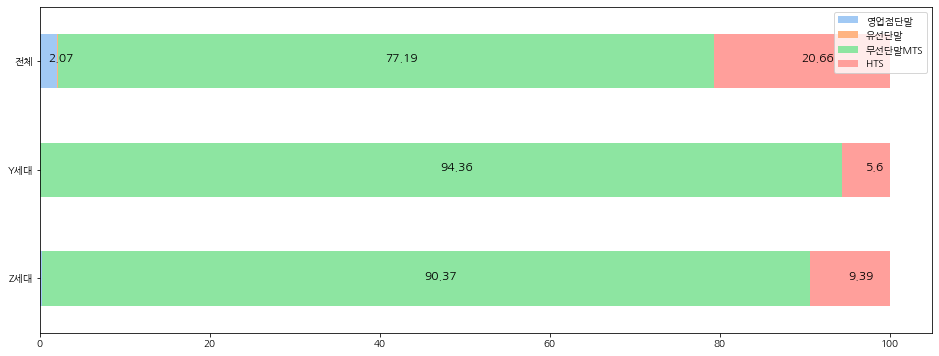

In [82]:
ax = df3.plot(kind='barh',stacked=True,figsize=(16,6))
ax.legend(df3.columns, bbox_to_anchor=[0, 0, 1, 1])
for i in range(len(df3)):
    temp=0
    for dfci in df3.iloc[i,:]:
        if dfci>1:
            ax.text(temp + dfci/2, i, round(dfci,2), color="black", fontsize=12)
            temp+=dfci
plt.show()

#### 
##### 예상대로 두 세대 모두 90%가 넘는 거래가 모바일로 이루어져 있었다. 그러나, 조금 의외였던건 Z세대에서의 홈트레이딩의 비율이었는데 이 비율이 Y세대보다 2배가량 높은 것을 확인할 수 있었다. 이는 최근 IT에서 떠오르는 주제인 머신러닝와 자동화 프로그램과 관련 있는 것으로 추측된다. 자동화 트레이딩이나 트레이딩 봇에 조금 더 관심을 가지고, 해당 기술을 터득하려는 모습을 Z세대에서 관측할 수 있다.

## 
### 2-5. 장전시간외 주문 접수 건 수 분석
#### 투자 성향 별 주문 접수 시간대
##### 주식 시장의 개장 시간은 오전 9시이다. 그러나 데이터를 잘 보면 개장 이전에 접수를 걸어둔 주문이 존재하는데, 해당 주문을 장전시간외 주문이라고 한다. 장전시간외 주문은 개장 시 주식의 가격 (시가)를 결정짓는데 영향을 주기 때문에 일반 시간대의 거래보다 분석적인 경향이 강하다고 할 수 있다. 해당 시간대에 분포하는 Y세대와 Z세대의 비율을 통해 그들의 분석 경향을 유추할 수 있다.

### 
#### 2-5-1. 주문 접수 시간대 분석

In [39]:
df1 = df.copy()

In [125]:
df_tmp = df1['orr_rtn_hur'].value_counts().sort_index()
bar = Bar("주문 접수 히스토그램", "orr_rtn_hur",title_pos='0%')
bar.add("접수 건수", df_tmp.index, df_tmp.values,legend_pos="25%")
bar.height = 500; bar.width = 800
bar

df_tmp = df1['lst_cns_hur'].value_counts().sort_index()
bar2 = Bar("최종 체결 히스토그램", "lst_cns_hur", title_pos = '50%')
bar2.add("접수 건수", df_tmp.index, df_tmp.values ,legend_pos="75%")
bar2.height = 500; bar.width = 800
bar2

grid = Grid()
grid.add(bar, grid_right='60%')
grid.add(bar2, grid_left="60%")
grid.height = 300; grid.width = 800
grid

### 
#### 2-5-2. 세대별 장전시간외 투자 분석

In [130]:
def recategorize(data, by):
    if by == 'ages':
        if data >= 20 and data < 30:
            return "Z세대"
        if data >= 30 and data < 40:
            return "Y세대"
        else:
            return "나머지세대"
    if by == 'times':
        if data == 7 or data == 8:
            return "장전시간외"
        else:
            return "나머지시간"

df2 = df1[df1['ivs_icn_cd'] != "-"].copy()
df2['cus_age'] = df1['cus_age'].apply(lambda x : recategorize(x, "ages"))
df2['orr_rtn_hur'] = df1['orr_rtn_hur'].apply(lambda x : recategorize(x, "times"))
df3 = df2.groupby(['orr_rtn_hur','cus_age','ivs_icn_cd'])['cus_id'].count().unstack()
df3.fillna(0, inplace=True)
df3.columns = ['정보제공미동의','안정형','안정추구형','위험중립형','적극투자형','공격투자형','전문투자자형']

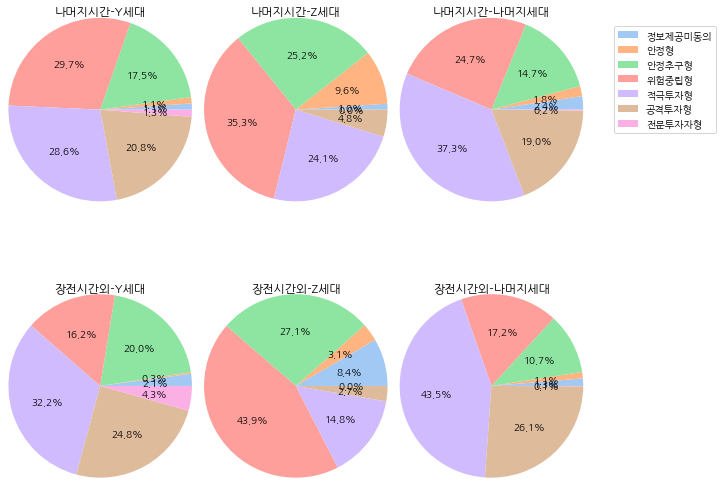

In [131]:
fig = plt.figure(figsize=(10,8))
for i, times in enumerate(df3.index.levels[0]):
    for j, ages in enumerate(df3.index.levels[1]):
        ax = fig.add_subplot(2,3,i*3+j+1)
        ax.pie(df3.loc[times,ages], radius=1.3, autopct="%.1f%%")
        ax.set_title(times+"-"+ages)
    if i==0:
        ax.legend(df3.columns, bbox_to_anchor=[1,0,0.8,1])        
plt.tight_layout() 
plt.show()

#### 
##### 장전시간외 거래 비율(위 3개) 과 다른 시간대(아래 3개)의 거래 비율을 비교해보면 그 경향성이 대체적으로 비슷하다는 것을 알 수 있다. Z세대를 제외한 나머지 세대의 경우 적극투자형의 장전시간외 거래 비율이 증가하는데, 이는 곧 적극투자형의 주식 투자 관심도가 가장 높다는 것으로 해석할 수 있다.

### 
#### 2-5-3. 장전시간 외, 나머지 시간의 비교

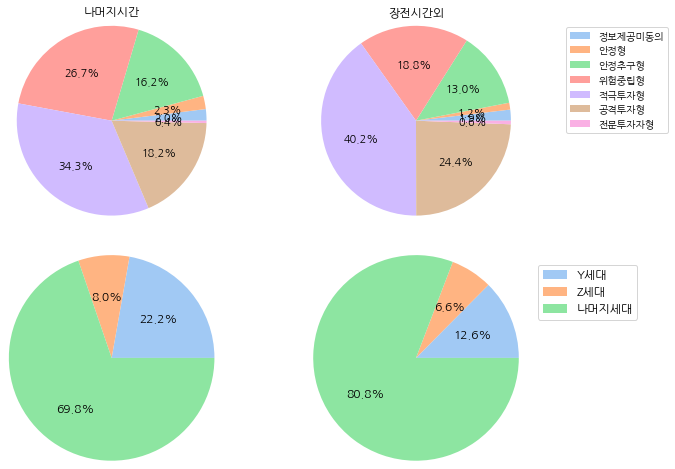

In [132]:
fig = plt.figure(figsize=(10,8))
for i, times in enumerate(df3.index.levels[0]):
    ax = fig.add_subplot(2,2,i+1)
    ax.pie(df3.loc[times].sum(),radius=1.2, autopct="%.1f%%", textprops={"fontsize":11}) #labels=df3.columns
    if i==1:
        ax.legend(df3.columns, bbox_to_anchor=[1,0,0.8,1])
    ax.set_title(times)
        
    ax = fig.add_subplot(2,2,i+3)
    ax.pie(df3.loc[times].sum(axis=1),radius=1.3, autopct="%.1f%%", textprops={"fontsize":12})
    if i==1:
        ax.legend(df3.index.levels[1], bbox_to_anchor=[1,0,0.65,1], fontsize=12)
plt.show()

#### 
##### 앞서 살펴보았던 6개의 파이 그래프와 마찬가지로, 적극투자형과 공격투자형의 투자 비율이 장전시간외에서 더 높게 나타나는 것을 확인할 수 있다. 역설하자면 안정형과 안정추구형은 개장 전에 주식에 투자하는 리스크를 감행하지 않거나, 주식의 흐름이 나타나기 전에는 투자를 안하는 경향을 드러낸다고 해석할 수도 있다. 또한 Y세대와 Z세대의 투자 비율을 살펴본 결과 Z세대는 투자 비율이 시간에 크게 영향을 받지 않는 것을 확인할 수 있다. 이번 그래프를 통해 Z세대는 조금더 공격적이고, Y세대는 조금 더 안정적인 성향을 띈다고 추측할 수 있다.

# 
## 3. 군집화
##### 우리들의 최종 목표는 Y세대와 Z세대의 특징을 파악하고, 이를 인사이트로 도출하는 것이다. 따라서 우리가 군집화할 대상은 총 3가지로 분류할 수 있는데, Y세대, Z세대, 그리고 나머지 세대이다. 세 집단에서 N개의 클러스터를 구하고 각 클러스터의 특징을 파악한 뒤 이를 비교하면 보다 확실하게 각 세대별 패턴을 파악할 수 있다. 먼저 예선에서는 Y세대와 Z세대를 한데 묶은 뒤 N개의 클러스터로 분류해 특징을 파악해보려고 한다.

## 
### 3.1. 데이터 로드 및 전처리
##### 군집 분석을 하기 위해 사용할 컬럼들을 선정하고 해당 컬럼들의 데이터를 군집 분석을 위한 데이터로 변형해줄 필요가 있다.

### 
#### 3.1.1 데이터 로드

In [115]:
#df = pd.read_csv("merged_s100.csv") #샘플링 데이터
df = pd.read_csv("merged_TKAC.csv")

### 
#### 3.1.1 고객등급, 고객투자성향, 연령대 전처리
##### 보다 확실한 해석을 위해 등급이 없거나 투자 성향이 없는 고객은 데이터에서 제외하였다.

In [116]:
df1 = df.copy()
df1 = df1[(df1['tco_cus_grd_cd']>='01') & (df1['tco_cus_grd_cd']<='05')]
df1 = df1[(df1['ivs_icn_cd']>='01') & (df1['ivs_icn_cd']<='05')]
df1 = df1[(df1['cus_age']>=20) & (df1['cus_age']<=35)]

### 
#### 3.1.2 고객 별 활동 금액 전처리
##### 각 체결 건 당 주식의 거래 가격과 수량이 나타나는데 계산을 통해 이를 'money' 컬럼으로 치환한다. 사용되는 돈은 사용자 별로 그 차이가 클 것으로 예상되기 때문에 Robustscaler를 사용하였다.

In [117]:
df1['money'] = df1['cns_qty'] * df1['orr_pr']
scaler = RobustScaler()
df1['money_scaled'] = scaler.fit_transform(df1['money'].values.reshape(-1,1))

### 
#### 3.1.3 우수 이용 고객 전처리
##### 본 군집 분석에서는 '고객의 활동'에 조금 더 초점을 맞출 예정이기 때문에, 지나치게 활동이 많은 고객의 경우 이상치로 분류할 필요가 있다. 또한 너무 거래가 적은 사용자들은 동일하게 '정보가 없는' 군집에 속하는데 이는 패턴 파악에 있어서 유용하지가 않다. 따라서 거래에 일정 횟수를 초과하거나 넘지 않는 고객을 데이터에서 제외시킨다.

In [118]:
gr1= df1.groupby('cus_id')
#df2 = gr1.filter(lambda x: (x['money'].count() >= 5) and (x['money'].count() <= 250))
df2 = gr1.filter(lambda x: (x['money'].count() >= 10))

### 
#### 3.1.4 주식 종목 전처리
##### 군집 분석을 자세하게 수행하기 위해서는 각 주식 종목간의 상관관계를 분석해야 할테지만, 본 분석에서는 간단하게 해당 종목의 거래 빈도를 기준으로 Robustscale을 수행하였다. 즉, 거래가 많은 종목들은 대중성이 강할 것이고, 거래가 적은 종목들은 대중성이 떨어질 것이라는 판단하에 거래 빈도를 모델 학습에 활용하기로 한다.

In [119]:
scaler = RobustScaler()
gr2_df = pd.DataFrame(df2.groupby('iem_cd')['money'].sum())
gr2_df['iem_scaled'] = scaler.fit_transform(gr2_df)
df2['iem_scaled'] = df2['iem_cd'].apply(lambda x: gr2_df.loc[x,'iem_scaled'])

### 
#### 3.1.5 고객 등급, 투자 성향 스케일링
##### 두 범주형 데이터는 정수형 데이터로 변환이 가능하지만, 이는 엄밀히 말하면 해당 범주의 밀도를 전혀 고려하지 않는 변환이 된다. 따라서 주식 종목과 마찬가지로 각 범주의 빈도를 구하여 StandardScaler를 사용해주었다.

In [120]:
scaler = StandardScaler()
gr2_df = pd.DataFrame(df2.groupby(['tco_cus_grd_cd'])['cus_id'].count())
gr2_df['grd_scaled'] = scaler.fit_transform(gr2_df.values.reshape(-1,1))
df2['grd_scaled'] = df2['tco_cus_grd_cd'].apply(lambda x: gr2_df.loc[x,'grd_scaled'])
gr2_df = pd.DataFrame(df2.groupby(['ivs_icn_cd'])['cus_id'].count())
gr2_df['icn_scaled'] = scaler.fit_transform(gr2_df.values.reshape(-1,1))
df2['icn_scaled'] = df2['ivs_icn_cd'].apply(lambda x: gr2_df.loc[x,'icn_scaled'])

### 
#### 3.1.6 구매, 판매 데이터 분류 및 사용금액 군집화
##### 앞서 살펴본 히스토그램에서 두 데이터는 1:1로 대응되지 않는 것을 확인했다. 게다가 모든 사람이 동일한 비율로 사고 팔지는 않을 것이다. 어떤 사람은 분할구매를, 또 어떤 사람은 분할판매를 하는 경향이 강할 것이다. 이를 확인하기 위해 특정 고객마다 얼마나 많은 금액을 사용하는지, 이를 군집화 하고자 한다. 즉, 가장 먼저 군집화 할 대상은 스케일링을 거친 재화 데이터이다.

In [121]:
dfB = df2[df2['sby_dit_cd'] == 2]['money_scaled']
dfS = df2[df2['sby_dit_cd'] == 1]['money_scaled']
scaler = MinMaxScaler()
dfB_scaled = scaler.fit_transform(dfB.values.reshape(-1,1))
dfS_scaled = scaler.fit_transform(dfS.values.reshape(-1,1))
df2_scaled = scaler.fit_transform(df2['money_scaled'].values.reshape(-1,1))

### 
#### 3.1.7 재화 데이터 군집을 위한 최적의 클러스터 개수 찾기
##### 구매, 판매 데이터를 기준으로 최적의 클러스를 찾아 이를 반영해준다.

In [122]:
k_range = range(2,8)
dfB_ans = []
dfS_ans = []
df2_ans = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dfB_scaled)
    dfB_ans.append(kmeans.inertia_)
    print("[dfB] k = ",k,"| inertia = ",kmeans.inertia_)
    kmeans.fit(dfS_scaled)
    dfS_ans.append(kmeans.inertia_)
    print("[k = {:}] Complete!".format(k))
    kmeans.fit(df2_scaled)
    df2_ans.append(kmeans.inertia_)
    print("[k = {:}] Complete!".format(k))    

[dfB] k =  2 | inertia =  2.2295532589923774
[k = 2] Complete!
[k = 2] Complete!
[dfB] k =  3 | inertia =  1.0662365575940185
[k = 3] Complete!
[k = 3] Complete!
[dfB] k =  4 | inertia =  0.6905273518706807
[k = 4] Complete!
[k = 4] Complete!
[dfB] k =  5 | inertia =  0.45125350289770805
[k = 5] Complete!
[k = 5] Complete!
[dfB] k =  6 | inertia =  0.3331256381872836
[k = 6] Complete!
[k = 6] Complete!
[dfB] k =  7 | inertia =  0.24098825641160362
[k = 7] Complete!
[k = 7] Complete!


In [123]:
line = Line("데이터 클러스터링","dfB, dfS")
line.add("dfB_ans", [str(2),str(3),str(4),str(5),str(6),str(7)], dfB_ans, legend_pos='25%')
line.height = 500; line.width = 800
line

line2 = Line()
line2.add("dfS_ans", [str(2),str(3),str(4),str(5),str(6),str(7)], dfS_ans, legend_pos='50%')

line3 = Line()
line3.add("df2_ans", [str(2),str(3),str(4),str(5),str(6),str(7)], df2_ans, legend_pos='70%')

overlap = Overlap()
overlap.add(line)
overlap.add(line2)
overlap.add(line3)
overlap.height = 500; overlap.width = 800
overlap

In [124]:
clB=3 ; clS=3

### 
#### 3.1.8. 재화 범주 변경해주기
##### 위의 클러스터 라벨을 기준으로 스케일링된 재화 거래 컬럼을 각각 0,1,2로 분류해준다.

In [125]:
kmeans = KMeans(n_clusters=clB, random_state=0)
kmeans.fit(dfB_scaled)
dfB_label = kmeans.labels_

kmeans = KMeans(n_clusters=clS, random_state=0)
kmeans.fit(dfS_scaled)
dfS_label = kmeans.labels_

df3 = df2[['cus_id','grd_scaled','icn_scaled','iem_scaled']].copy()
df3['money_cluster'] = '-'
df3.loc[dfB.index,'money_cluster'] = dfB_label
df3.loc[dfS.index,'money_cluster'] = dfS_label+clB

### 
#### 3.1.10. 모델 최종 선정
##### 최종적으로 스케일된 고객 등급, 투자성향, 그리고 거래 패턴(가격 분류에 따른 구매, 판매 데이터) 를 군집 분류 모델에 반영한다.

In [126]:
gr3 = df3.groupby(['cus_id','grd_scaled','icn_scaled','money_cluster'])['grd_scaled'].count().unstack()
gr3 = gr3.fillna(0)

scaler = StandardScaler()
df4 = pd.DataFrame(scaler.fit_transform(gr3), index=gr3.index)

df4 = df4.reset_index(level=[1,2])
df4 #grd_scaled : 고객 등급, icn_scaled : 투자 성향 , [0,1,2] : 구매패턴(소액,중액,고액), [3,4,5] : 판매패턴(소액,중액, 고액)

,grd_scaled,icn_scaled,0,1,2,3,4,5
cus_id,,,,,,,,
000ffabe461b9b0f5360913aa1b340e84e44446617a8dc14110f59cca1802d42,0.043785,1.147367,-0.038037,-0.034052,-0.031189,0.034850,-0.031189,-0.034545
002ba4c026c150d2e1db921064d48b62fee6d88a56831f1299f45e7ad6dd9206,1.350150,1.147367,-0.250915,-0.034052,-0.031189,-0.207069,-0.031189,-0.034545
00d3b315b2b9132f1dbe7863d08f78e0d35d4aacb5fb7240afc419026d62eaae,0.043785,0.882150,0.049152,-0.034052,-0.031189,0.186966,-0.031189,-0.034545
00f85930ccfb3b2e86b569ab28009295a8b19e22471432d0f75c984a4367130b,1.350150,0.882150,-0.239592,-0.034052,-0.031189,-0.306036,-0.031189,-0.034545
0104b9c9616a4a60ff5ca0b845aee774c93d10d8cc740aab136837fb479e18cf,0.830281,-0.370622,0.460189,-0.034052,-0.031189,0.060508,-0.031189,-0.034545
...,...,...,...,...,...,...,...,...
fe343240aa173c5b64c347e8b18a74bb7b2fb41be5b19e599234cfd1828e64ba,0.830281,-0.370622,-0.336973,-0.034052,-0.031189,-0.328029,-0.031189,-0.034545
fe755740ca381c151db298b62f1bac843afcf27e8acb4e9f764b30c6c3b75c6c,1.350150,-0.370622,-0.100315,-0.034052,-0.031189,-0.190575,-0.031189,-0.034545
ff3b0b0462bb8d81e7fed711110932882fabc1bbad659d1a27ef7549713d31a6,0.043785,0.882150,-0.347164,-0.034052,-0.031189,-0.331694,-0.031189,-0.034545


## 
### 3.2. 군집 분석 및 모델 평가

### 
#### 3.2.1. 차원 축소 (PCA)
##### 우리 데이터는 총 10차원으로 이루어져 있기 때문에, 3개의 차원으로 축소시키기 위해 PCA를 사용한다.

In [177]:
pca = PCA(n_components=3)  # 3차원으로 축소
data = pca.fit_transform(df4)

In [178]:

scatter1 = Scatter("PCA")
scatter1.add("", data[:,0], data[:,1], symbol_size = 4)

scatter2= Scatter("PCA")
scatter2.add("", data[:,1], data[:,2], symbol_size = 4)

scatter3 = Scatter("PCA")
scatter3.add("", data[:,2], data[:,0], symbol_size = 4 )

grid = Grid()
grid.add(scatter1, grid_right='70%')
grid.add(scatter2, grid_right='40%', grid_left='40%')
grid.add(scatter3, grid_left="70%")
grid.height = 300; grid.width = 800
grid

### 
#### 3.2.2. 이상치 제거
##### 그래프 분석 결과, 다른 데이터들에 비해 유난히 값이 큰 2개의 점을 발견할 수 있었다. 데이터를 범위 인덱싱을 통해 해당 이상치 2개를 제외시키고 군집 분석을 수행한다.

In [179]:

data = data[data[:,0]<10]
#data = data[data[:,1]<15]
#data = data[data[:,2]<3]
#이상치 데이터 2개 날림

In [180]:
scatter1 = Scatter("PCA")
scatter1.add("", data[:,0], data[:,1], symbol_size = 4)

scatter2= Scatter("PCA")
scatter2.add("", data[:,1], data[:,2], symbol_size = 4)

scatter3 = Scatter("PCA")
scatter3.add("", data[:,2], data[:,0], symbol_size = 4 )

grid = Grid()
grid.add(scatter1, grid_right='70%')
grid.add(scatter2, grid_right='40%', grid_left='40%')
grid.add(scatter3, grid_left="70%")
grid.height = 300; grid.width = 800
grid

### 
#### 3.2.3. 최적의 클러스터 판단
##### 앞서 수행한 kmeans와 마찬가지로 최적의 클러스터 개수를 찾는다.

In [181]:
data_ans = []
k_range = range(2,8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    data_ans.append(kmeans.inertia_)

In [182]:
line = Line("데이터 클러스터링","data")
line.add("data_ans", [str(2),str(3),str(4),str(5),str(6),str(7)], data_ans, legend_pos='25%')
line.height = 500; line.width = 800
line

### 
#### 3.2.4. 군집 분류 결과 시각화
##### 각 클러스터 별로 다른 색으로 표현된 그래프를 그려 어떻게 군집이 나뉘어지는지 판단한다.

In [183]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data)
data_label = kmeans.labels_

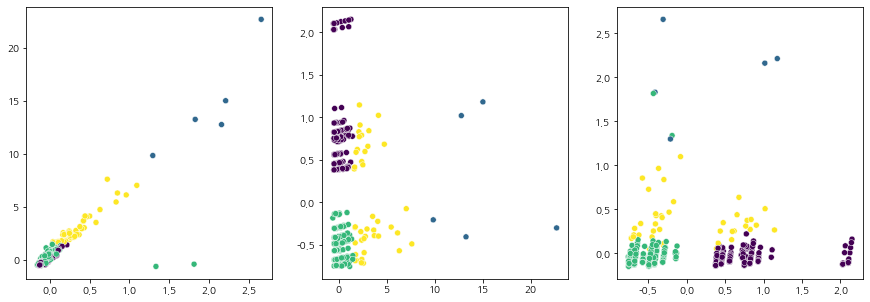

In [184]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,3,1)
sns.scatterplot(x=data[:,0],y=data[:,1],ax=ax,c=data_label)
ax = plt.subplot(1,3,2)
sns.scatterplot(x=data[:,1],y=data[:,2],ax=ax,c=data_label)
ax = plt.subplot(1,3,3)
sns.scatterplot(x=data[:,2],y=data[:,0],ax=ax,c=data_label)
plt.show()

#### 
##### 각 축을 제외한 3개의 2차원 산점도 그래프를 비교해본 결과, 총 4개의 군집으로 나누었을 때, 그 중 하나의 군집은 단순히 "거래량이 많은" 데이터들의 집단으로 표현된다. 이는 군집 분류 의사 결정에서 시계열 정보가 들어가지 않고 거래 횟수로만 판단하기 때문에 생긴 결과로 추측된다. 또한, 범주형 데이터 였던 고객등급이나 고객투자성향에 구애받지 않고 전체적으로 4개의 군집으로 분류되었기 때문에 해당 군집별 고객등급, 고객투자성향의 비율을 분석하면 각 군집이 어떤 패턴을 띄는지, 그리고 고객 등급과 고객 투자 성향에는 어떤 상관관계가 있는지 분석할 수 있을 것이다.

In [185]:
scatter3D = Scatter3D()
scatter3D.add("",data[data_label==0])
scatter3D.add("",data[data_label==1])
scatter3D.add("",data[data_label==2])
scatter3D.add("",data[data_label==3])
scatter3D


In [171]:

ar = np.concatenate((data, data_label.reshape(-1,1)), axis=1)
df5 = pd.DataFrame(ar)
df6 = pd.DataFrame(pca.fit_transform(df4))

In [175]:
df5

,0,1,2,3
0,-0.038939,0.038238,-0.560145,2.0
1,-0.129632,-0.303852,-0.748322,2.0
2,-0.010121,0.197300,-0.292418,2.0
3,-0.142612,-0.370383,-0.489644,2.0
4,-0.031017,0.357555,0.832026,0.0
...,...,...,...,...
1023,-0.123801,-0.479713,0.821413,0.0
1024,-0.110617,-0.225772,0.753701,0.0
1025,-0.106369,-0.440775,-0.309916,2.0
1026,-0.118255,-0.445469,0.822493,0.0


In [176]:
df6

,0,1,2
0,-0.038939,0.038238,-0.560145
1,-0.129632,-0.303852,-0.748322
2,-0.010121,0.197300,-0.292418
3,-0.142612,-0.370383,-0.489644
4,-0.031017,0.357555,0.832026
...,...,...,...
1024,-0.123801,-0.479713,0.821413
1025,-0.110617,-0.225772,0.753701
1026,-0.106369,-0.440775,-0.309916
1027,-0.118255,-0.445469,0.822493
